# 03 — Exploratory Data Analysis (EDA) on images

Obiettivo: capire **cosa abbiamo** prima di addestrare modelli.

In questo notebook:
- Carichiamo i metadati dal DB (PostgreSQL)
- Analizziamo distribuzione classi e split
- Verifichiamo proprietà delle immagini (dimensioni, canali)
- Visualizziamo esempi per classe e split
- Calcoliamo statistiche semplici sui pixel (campione) per verificare range/normalizzazione

> Nota: la pipeline dati è definita in `src/garbagecls/*`. Qui facciamo solo EDA (grafici, check e commenti).


## 0) Setup import e path (src)

Assumiamo la struttura:
- `src/garbagecls/db.py`
- `src/garbagecls/paths.py`


In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name.lower() == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from garbagecls.db import load_env, read_images_df, split_dfs
from garbagecls.paths import PROJECT_ROOT, abs_path


## 1) Caricamento metadati dal DB

In [3]:
load_env()
df = read_images_df(source="raw_flat")
print("Totale immagini:", len(df))
display(df.head())


Totale immagini: 2527


c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


,image_id,filepath,label,split,width,height,channels,source
0,1,data/raw_flat/plastic/plastic92.jpg,plastic,train,512,384,3,raw_flat
1,2,data/raw_flat/cardboard/cardboard305.jpg,cardboard,train,512,384,3,raw_flat
2,3,data/raw_flat/cardboard/cardboard53.jpg,cardboard,train,512,384,3,raw_flat
3,4,data/raw_flat/cardboard/cardboard42.jpg,cardboard,train,512,384,3,raw_flat
4,5,data/raw_flat/metal/metal141.jpg,metal,train,512,384,3,raw_flat


### 1.1 Split counts

split
train    1768
test      380
val       379
Name: count, dtype: int64

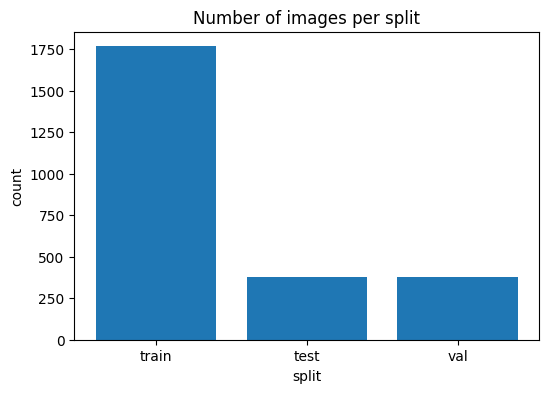

In [4]:
split_counts = df["split"].value_counts()
display(split_counts)

plt.figure(figsize=(6,4))
plt.bar(split_counts.index, split_counts.values)
plt.title("Number of images per split")
plt.xlabel("split")
plt.ylabel("count")
plt.show()


### 1.2 Class distribution (overall)

label
cardboard    403
glass        501
metal        410
paper        594
plastic      482
trash        137
Name: count, dtype: int64

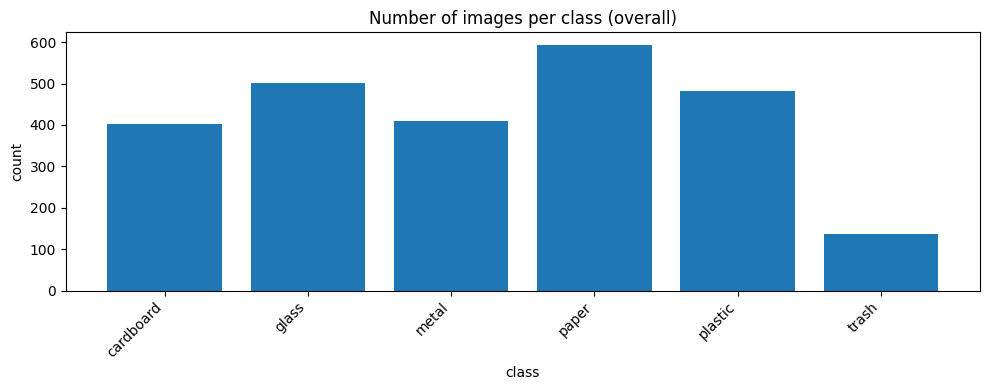

In [5]:
label_counts = df["label"].value_counts().sort_index()
display(label_counts)

plt.figure(figsize=(10,4))
plt.bar(label_counts.index, label_counts.values)
plt.title("Number of images per class (overall)")
plt.xlabel("class")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 1.3 Class distribution by split

In [6]:
print("Split counts:")
display(df["split"].value_counts())

print("\nLabel counts (top 10):")
display(df["label"].value_counts().head(10))

# Mostriamo per ogni split come sono suddivise le classi
for split_name in ["train", "val", "test"]:
    split_df = df[df["split"] == split_name]
    print(f"\n{split_name.upper()} - Label distribution (%):")
    label_pct = (split_df["label"].value_counts(normalize=True) * 100).round(2)
    display(label_pct)


Split counts:


split
train    1768
test      380
val       379
Name: count, dtype: int64


Label counts (top 10):


label
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64


TRAIN - Label distribution (%):


label
paper        23.53
glass        19.80
plastic      19.06
metal        16.23
cardboard    15.95
trash         5.43
Name: proportion, dtype: float64


VAL - Label distribution (%):


label
paper        23.48
glass        19.79
plastic      19.00
cardboard    16.09
metal        16.09
trash         5.54
Name: proportion, dtype: float64


TEST - Label distribution (%):


label
paper        23.42
glass        20.00
plastic      19.21
metal        16.32
cardboard    15.79
trash         5.26
Name: proportion, dtype: float64

Proporzioni corrette

split,test,train,val
label,,,
cardboard,60,282,61
glass,76,350,75
metal,62,287,61
paper,89,416,89
plastic,73,337,72
trash,20,96,21


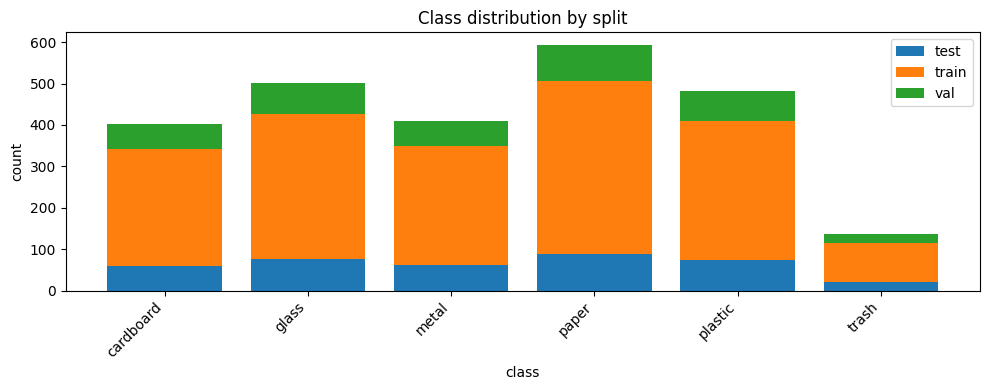

In [7]:
pivot = pd.pivot_table(
    df, index="label", columns="split", values="image_id",
    aggfunc="count", fill_value=0
).sort_index()
display(pivot)

plt.figure(figsize=(10,4))
bottom = np.zeros(len(pivot))
for split in pivot.columns:
    plt.bar(pivot.index, pivot[split].values, bottom=bottom, label=split)
    bottom += pivot[split].values

plt.title("Class distribution by split")
plt.xlabel("class")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


Confermato anche graficamente

## 2) Check proprietà immagini (da metadati)

Se nel DB avete aggiunto `width/height/channels`, qui li sfruttiamo per verifiche veloci.


Width/height/channels disponibili nel DB ✅


,width,height,channels
count,2527.0,2527.0,2527.0
mean,512.0,384.0,3.0
std,0.0,0.0,0.0
min,512.0,384.0,3.0
25%,512.0,384.0,3.0
50%,512.0,384.0,3.0
75%,512.0,384.0,3.0
max,512.0,384.0,3.0


channels
3    2527
Name: count, dtype: int64

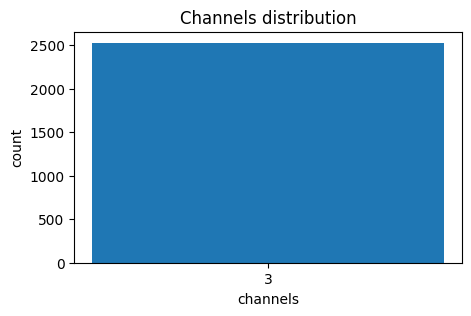

width  height
512    384       2527
dtype: int64

In [8]:
cols = ["width", "height", "channels"]
if all(c in df.columns for c in cols) and df[cols].notna().all().all():
    print("Width/height/channels disponibili nel DB ✅")
    display(df[cols].describe())

    ch_counts = df["channels"].value_counts().sort_index()
    display(ch_counts)

    plt.figure(figsize=(5,3))
    plt.bar(ch_counts.index.astype(str), ch_counts.values)
    plt.title("Channels distribution")
    plt.xlabel("channels")
    plt.ylabel("count")
    plt.show()

    wh_counts = df.groupby(["width","height"]).size().sort_values(ascending=False).head(10)
    display(wh_counts)
else:
    print("Width/height/channels non disponibili o incompleti. (Ok: si può fare EDA senza.)")


## 3) Visualizzazione esempi immagini

Visualizziamo:
- esempi casuali globali
- esempi per classe (train)

> Nota: usiamo `abs_path()` per risolvere i `filepath` relativi salvati nel DB.


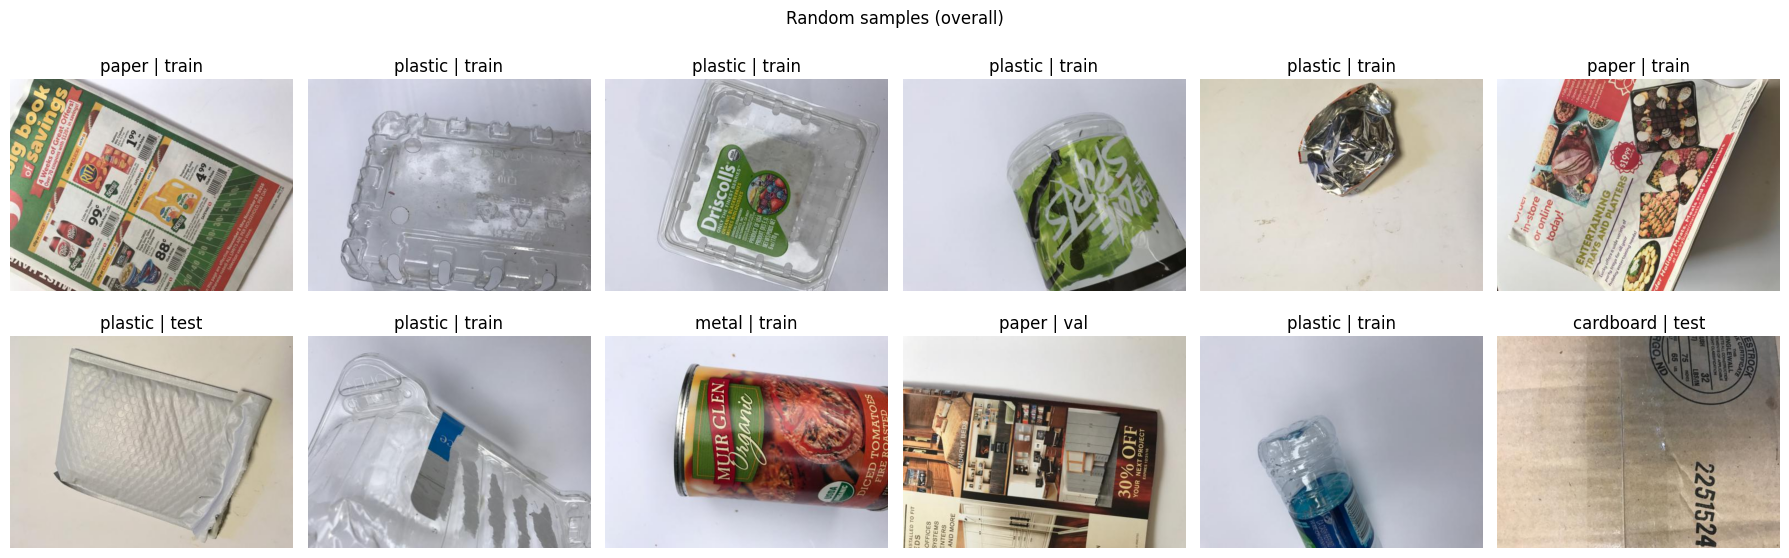

In [9]:
def show_random_images(df_in, n=12, title="Random samples"):
    df_s = df_in.sample(min(n, len(df_in)), random_state=42).reset_index(drop=True)
    n = len(df_s)
    cols = 6
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(n):
        p = abs_path(df_s.loc[i, "filepath"])
        ax = plt.subplot(rows, cols, i+1)
        try:
            img = Image.open(p).convert("RGB")
            plt.imshow(img)
            plt.title(f"{df_s.loc[i,'label']} | {df_s.loc[i,'split']}")
        except Exception as e:
            plt.text(0.1, 0.5, f"Error\n{e}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_random_images(df, n=12, title="Random samples (overall)")


### 3.1 Esempi per classe (train)

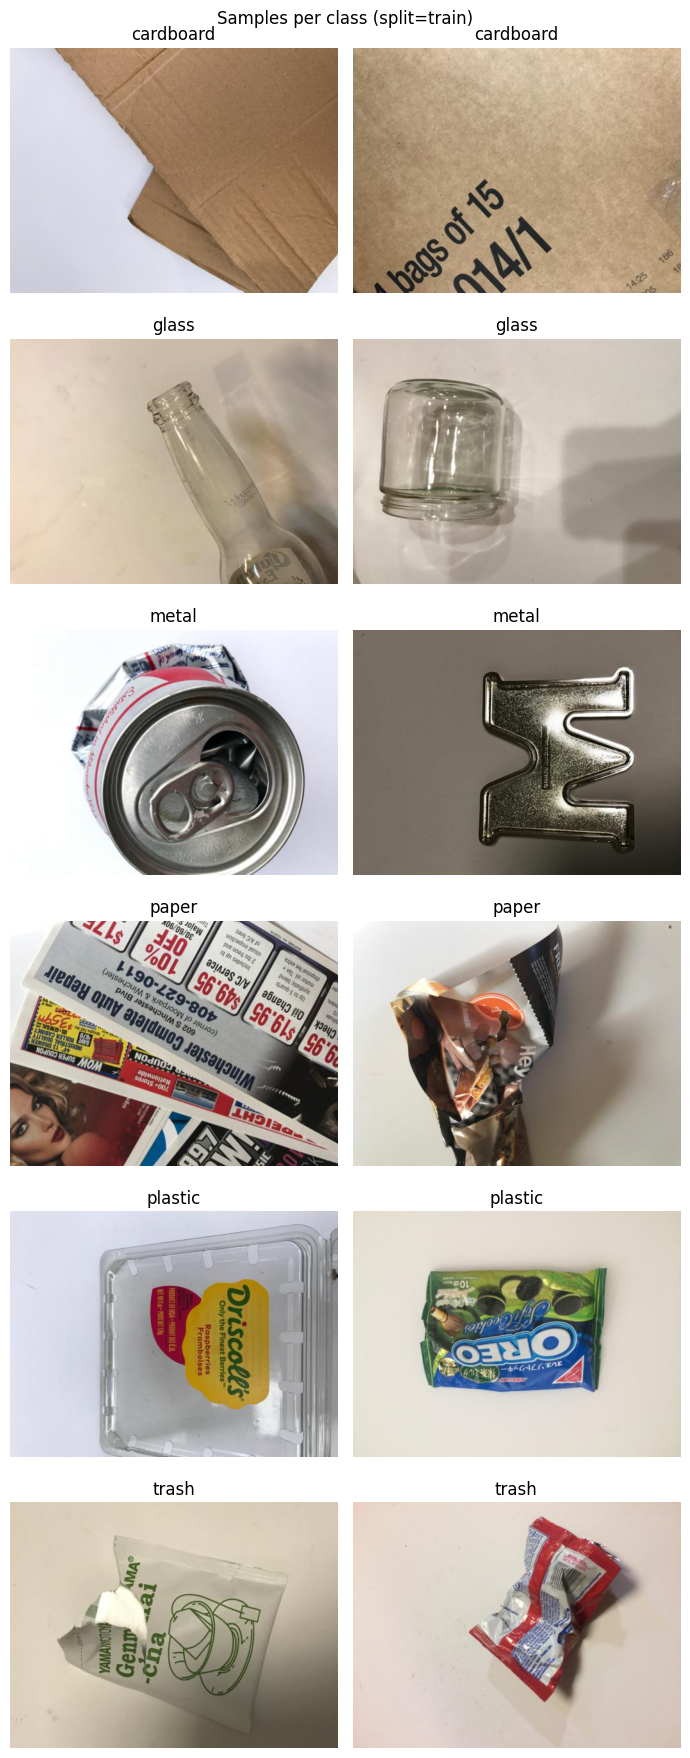

In [10]:
def show_samples_per_class(df_in, per_class=2, split="train"):
    df_in = df_in[df_in["split"] == split]
    labels = sorted(df_in["label"].unique())

    cols = per_class
    rows = len(labels)
    plt.figure(figsize=(cols*3.5, rows*3))

    idx = 1
    for lab in labels:
        df_lab = df_in[df_in["label"] == lab]
        if len(df_lab) == 0:
            continue
        df_s = df_lab.sample(min(per_class, len(df_lab)), random_state=42).reset_index(drop=True)
        for j in range(len(df_s)):
            p = abs_path(df_s.loc[j, "filepath"])
            ax = plt.subplot(rows, cols, idx)
            try:
                img = Image.open(p).convert("RGB")
                plt.imshow(img)
                plt.title(lab)
            except Exception as e:
                plt.text(0.1, 0.5, f"Error\n{e}")
            plt.axis("off")
            idx += 1

    plt.suptitle(f"Samples per class (split={split})")
    plt.tight_layout()
    plt.show()

show_samples_per_class(df, per_class=2, split="train")


## 4) Pixel intensity distribution (su campione)

Calcoliamo statistiche semplici su un **campione** (per evitare di leggere tutte le immagini).
Questo serve solo per verificare:
- range (0–255 prima della normalizzazione)
- media globale indicativa


In [11]:
def pixel_stats_sample(df_in, n=200, seed=42):
    df_s = df_in.sample(min(n, len(df_in)), random_state=seed).reset_index(drop=True)
    mins, maxs, means = [], [], []

    for i in range(len(df_s)):
        p = abs_path(df_s.loc[i, "filepath"])
        img = Image.open(p).convert("RGB")
        arr = np.asarray(img, dtype=np.float32)  # 0..255
        mins.append(arr.min())
        maxs.append(arr.max())
        means.append(arr.mean())

    return float(np.min(mins)), float(np.max(maxs)), float(np.mean(means))

mn, mx, mu = pixel_stats_sample(df, n=200)
print("Pixel intensity stats (sample, raw images):")
print("Min:", mn)
print("Max:", mx)
print("Mean:", mu)

Pixel intensity stats (sample, raw images):
Min: 0.0
Max: 255.0
Mean: 166.11395263671875


Min: 0
Max: 255
Mean: 155.02240329318576


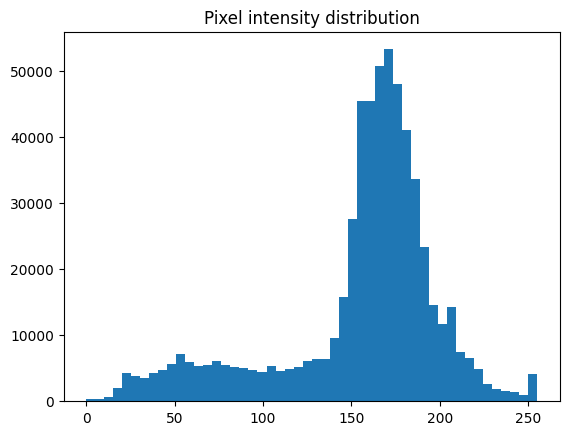

In [12]:
img = np.array(Image.open(abs_path(df.iloc[0]["filepath"])))

print("Min:", img.min())
print("Max:", img.max())
print("Mean:", img.mean())

plt.hist(img.flatten(), bins=50)
plt.title("Pixel intensity distribution")
plt.show()

La pixel intensiti ci mostra che le immagini sono in un intervallo standard 0-255, senza anomalie evidenti.

## 5) Note EDA (da riportare nel report)

- Distribuzione classi: le classi sono abbastanza bilanciate, solo `trash` è leggermente sotto-rappresentata.
- Split: effettuato in modo corretto e coerente
- Background e lighting: possibile variabilità
- Dimensioni/canali: uniformi, preprocessing più semplice

Vediamo che in trash è inserita spesso anche plastica e carta. Di fatto la semantica del database considera trash la spazzatura piccola, traducibile come "cartacce".  
Per il caricamento di immagini esterne dobbiamo tenerlo in considerazione
